In [1]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt

### Creating a one bus for the Netherlands

In [2]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)


network.add("Bus", "electricity bus", carrier="electricity")
network.add("Carrier", "electricity")  

network.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

#### Getting the demand for the Netherlands and adding it to the bus

In [3]:
# Define file path
file_path = "Data/electricity_demand.csv"

# Load dataset
data = pd.read_csv(file_path, sep=';', parse_dates=['utc_time'], index_col='utc_time')
data.index = pd.to_datetime(data.index, utc=True)
# Convert index to datetime format
data.index = pd.to_datetime(data.index, utc=True)

start_date = '2015-01-01 00:00:00+00:00'
end_date = '2015-12-31 23:00:00+00:00'

data = data[start_date:end_date]
country = 'NLD'
data = data[country]
print(data.head())

utc_time
2015-01-01 00:00:00+00:00    11338.0
2015-01-01 01:00:00+00:00    10917.0
2015-01-01 02:00:00+00:00    10473.0
2015-01-01 03:00:00+00:00    10200.0
2015-01-01 04:00:00+00:00    10182.0
Name: NLD, dtype: float64


In [4]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set = data.values)

Index(['load'], dtype='object')

In [5]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,11338.0
2015-01-01 01:00:00,10917.0
2015-01-01 02:00:00,10473.0
2015-01-01 03:00:00,10200.0
2015-01-01 04:00:00,10182.0
...,...
2015-12-31 19:00:00,12958.0
2015-12-31 20:00:00,12263.0
2015-12-31 21:00:00,11772.0


#### Adding different generation types 

In [6]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n
    
print(annuity(25,0.07))
print(annuity(25,0.07)*425000*(1+0.03))

0.0858105172206656
37563.55391334636


In [7]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "coal", co2_emissions=0.363) # in /MWh_tt_CO2h
network.add("Carrier", "offshorewind")
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")
network.add("Carrier", "nuclear")
network.add("Carrier", "CCGT", co2_emissions=0.22) # in /MWh_tt_CO2h



# add onshore wind generator
df_onshorewind = pd.read_csv('Data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind_on = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(30,0.07)*1088000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=7000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_on.values)

# add offshore wind generator
df_offshorewind = pd.read_csv('Data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
CF_wind_off = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_offshorewind = annuity(30,0.07)*2084520*(1+0.033) # in €/MW
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=7000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_off.values)

# add solar PV generator
df_solar = pd.read_csv('Data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*600290*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# add Gas CC W/o ccts
capital_cost_CCGT = annuity(30,0.07)*1300000*(1+0.033) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.58 # MWh_elec/MWh_th
VOM_gas = 4 # in €/MWh
marginal_cost_CCGT = VOM_gas + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "CCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="CCGT",
            #p_nom_max=7000,
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)


# add coal power plant  generator coal IGCC W/o ccts
capital_cost_coal = annuity(40,0.07)*3088000*(1+0.03) # in €/MW
fuel_cost = 8.4 # in €/MWh_th
efficiency = 0.392 # MWh_elec/MWh_th
VOM_coal = 6 # in €/MWh
marginal_cost_coal = VOM_coal + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "coal",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=7000,
            capital_cost = capital_cost_coal,
            marginal_cost = marginal_cost_coal)


# add nuclear power plant generator
capital_cost_nuclear = annuity(45,0.07)*8594000*(1+0.027) # in €/MW
fuel_cost = 3 # in €/MWh_th 
efficiency = 0.33 # MWh_elec/MWh_th
VOM_nuclear = 10 # in €/MWh
marginal_cost_nuclear = VOM_nuclear + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "nuclear",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="nuclear",
            #p_nom_max=7000,
            capital_cost = capital_cost_nuclear,
            marginal_cost = marginal_cost_nuclear)

Index(['nuclear'], dtype='object')

In [8]:
network.generators_t.p_max_pu

Generator,offshorewind,onshorewind,solar
snapshot,,,
2015-01-01 00:00:00,0.734,0.360,0.0
2015-01-01 01:00:00,0.758,0.383,0.0
2015-01-01 02:00:00,0.787,0.417,0.0
2015-01-01 03:00:00,0.794,0.432,0.0
2015-01-01 04:00:00,0.802,0.443,0.0
...,...,...,...
2015-12-31 19:00:00,0.798,0.448,0.0
2015-12-31 20:00:00,0.798,0.465,0.0
2015-12-31 21:00:00,0.794,0.451,0.0


In [9]:
network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})
print("Objective function value:", network.objective)

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 12.49it/s]
INFO:linopy.io: Writing time: 1.16s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-9kxhckoy.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-9kxhckoy.lp


Reading time = 0.39 seconds


INFO:gurobipy:Reading time = 0.39 seconds


obj: 113886 rows, 52566 columns, 205855 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 205855 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 6.57e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Objective function value: 6573712049.064885


In [10]:
print(network.objective/1000000) #in 10^6 €

6573.712049064885


In [11]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    58.046086
dtype: float64


In [12]:
network.generators.p_nom_opt # in MW

Generator
onshorewind      1083.333333
offshorewind        0.000000
solar               0.000000
CCGT            17545.250000
coal                0.000000
nuclear             0.000000
Name: p_nom_opt, dtype: float64

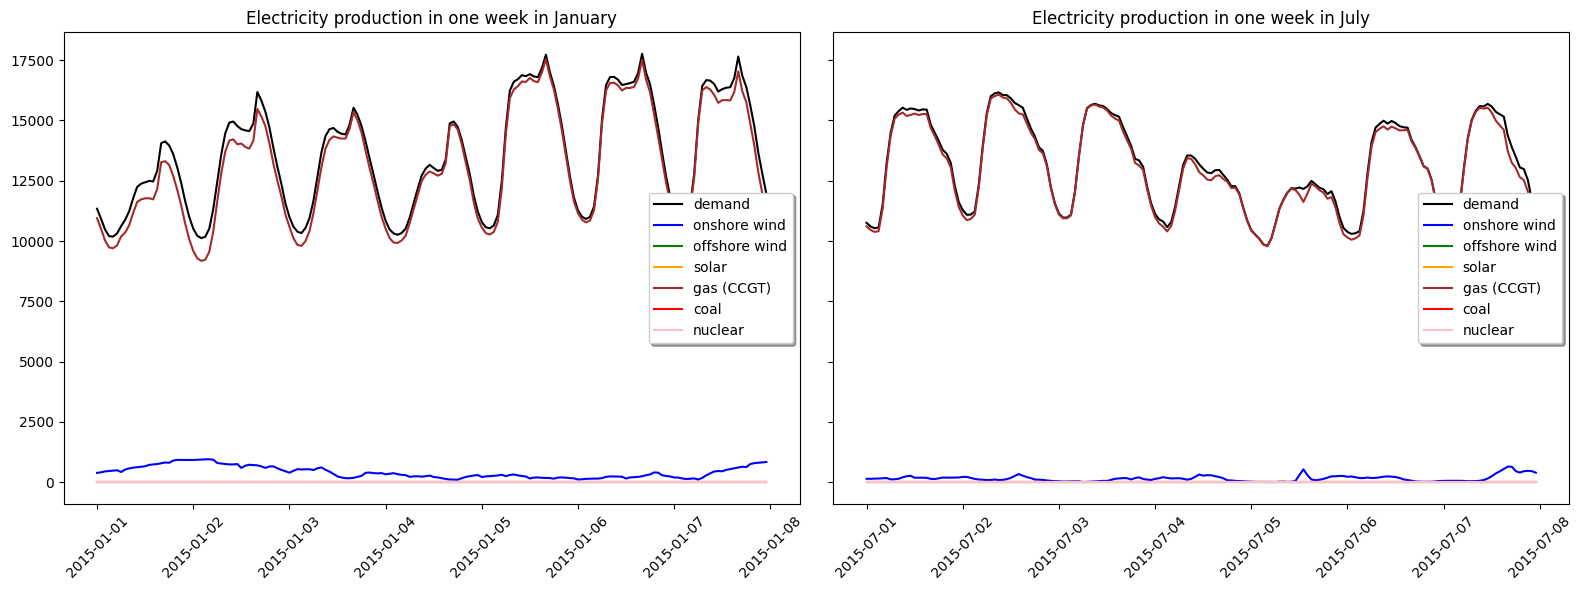

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Electricity mix

Text(0.5, 1.07, 'Electricity mix')

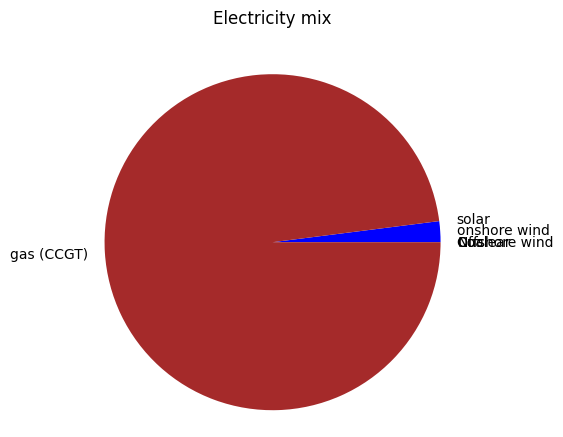

In [14]:
labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum(),
        network.generators_t.p['nuclear'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'red', 'pink']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [15]:
# Group dispatch by carrier manually
dispatch = network.generators_t.p
carrier_map = network.generators.carrier

# Match generator names to carriers
dispatch.columns = carrier_map[dispatch.columns].values

C:\Users\Julia\AppData\Local\Temp\ipykernel_24664\1457957073.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  carrier_dispatch = dispatch.groupby(axis=1, level=0).sum()


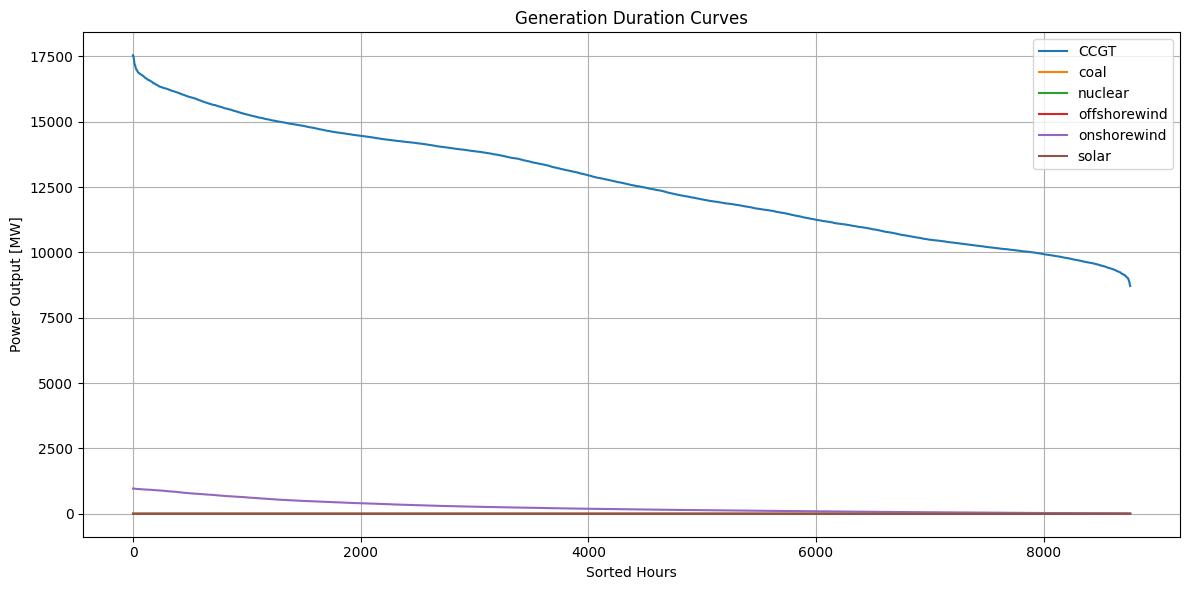

In [16]:
# Sum all generators by carrier
carrier_dispatch = dispatch.groupby(axis=1, level=0).sum()
# Duration curves
carrier_dispatch.apply(lambda x: x.sort_values(ascending=False).reset_index(drop=True)).plot(
    figsize=(12, 6), title="Generation Duration Curves")
plt.ylabel("Power Output [MW]")
plt.xlabel("Sorted Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

## CO2 limit 

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 12.09it/s]
INFO:linopy.io: Writing time: 1.22s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-advf_vk4.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-advf_vk4.lp


Reading time = 0.38 seconds


INFO:gurobipy:Reading time = 0.38 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Annual electricity generation per generator type (in GWh):

onshorewind       2272.618833
offshorewind         0.000000
solar                0.000000
CCGT                 0.000000
coal                 0.000000
nuclear         110977.258167
dtype: float64


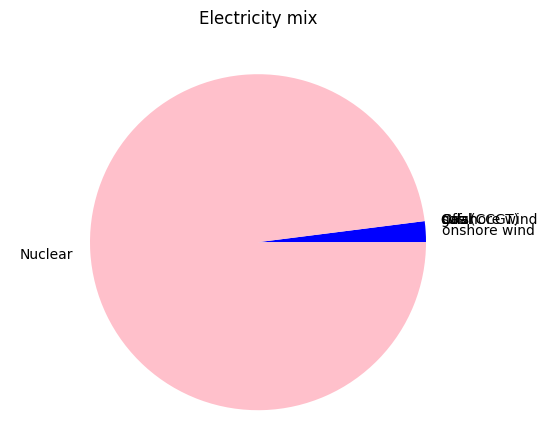

In [17]:
co2_limit=0#tonCO2
network.add("GlobalConstraint",
            "co2_limit_13MT",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit, 
            overwrite=True)

#network.optimize(solver_name='gurobi')
network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})



labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum(),
        network.generators_t.p['nuclear'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'red', 'pink']    

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

network.generators.p_nom_opt # in MW

generation_mwh = network.generators_t.p.sum()  # Sum over all hours → MWh
generation_gwh = generation_mwh / 1000         # Convert MWh to GWh

# Print results
print("Annual electricity generation per generator type (in GWh):\n")
print(generation_gwh)

In [18]:
print("objective function value:", network.objective/1000000)

objective function value: 13598.554986190707


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 12.24it/s]
INFO:linopy.io: Writing time: 1.2s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-7glugk5t.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-7glugk5t.lp


Reading time = 0.43 seconds


INFO:gurobipy:Reading time = 0.43 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s]
INFO:linopy.io: Writing time: 1.17s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-p6t1slxx.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-p6t1slxx.lp


Reading time = 0.41 seconds


INFO:gurobipy:Reading time = 0.41 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.01e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 12.72it/s]
INFO:linopy.io: Writing time: 1.19s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-hbon77tm.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-hbon77tm.lp


Reading time = 0.38 seconds


INFO:gurobipy:Reading time = 0.38 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 9.22e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.13it/s]
INFO:linopy.io: Writing time: 1.23s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-qhw2fksw.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-qhw2fksw.lp


Reading time = 0.52 seconds


INFO:gurobipy:Reading time = 0.52 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 8.49e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s]
INFO:linopy.io: Writing time: 1.17s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-v1y2mk8y.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-v1y2mk8y.lp


Reading time = 0.40 seconds


INFO:gurobipy:Reading time = 0.40 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 7.81e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]
INFO:linopy.io: Writing time: 1.08s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-773295kt.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-773295kt.lp


Reading time = 0.38 seconds


INFO:gurobipy:Reading time = 0.38 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 7.22e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  8.87it/s]
INFO:linopy.io: Writing time: 1.68s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-2a1jaart.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-2a1jaart.lp


Reading time = 0.56 seconds


INFO:gurobipy:Reading time = 0.56 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 6.90e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.01it/s]
INFO:linopy.io: Writing time: 1.09s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-r3trzdng.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-r3trzdng.lp


Reading time = 0.36 seconds


INFO:gurobipy:Reading time = 0.36 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 6.74e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s]
INFO:linopy.io: Writing time: 1.5s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-52ioalel.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-52ioalel.lp


Reading time = 0.45 seconds


INFO:gurobipy:Reading time = 0.45 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 6.64e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]
INFO:linopy.io: Writing time: 1.71s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-kd8fqed9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-kd8fqed9.lp


Reading time = 0.48 seconds


INFO:gurobipy:Reading time = 0.48 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 6.60e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


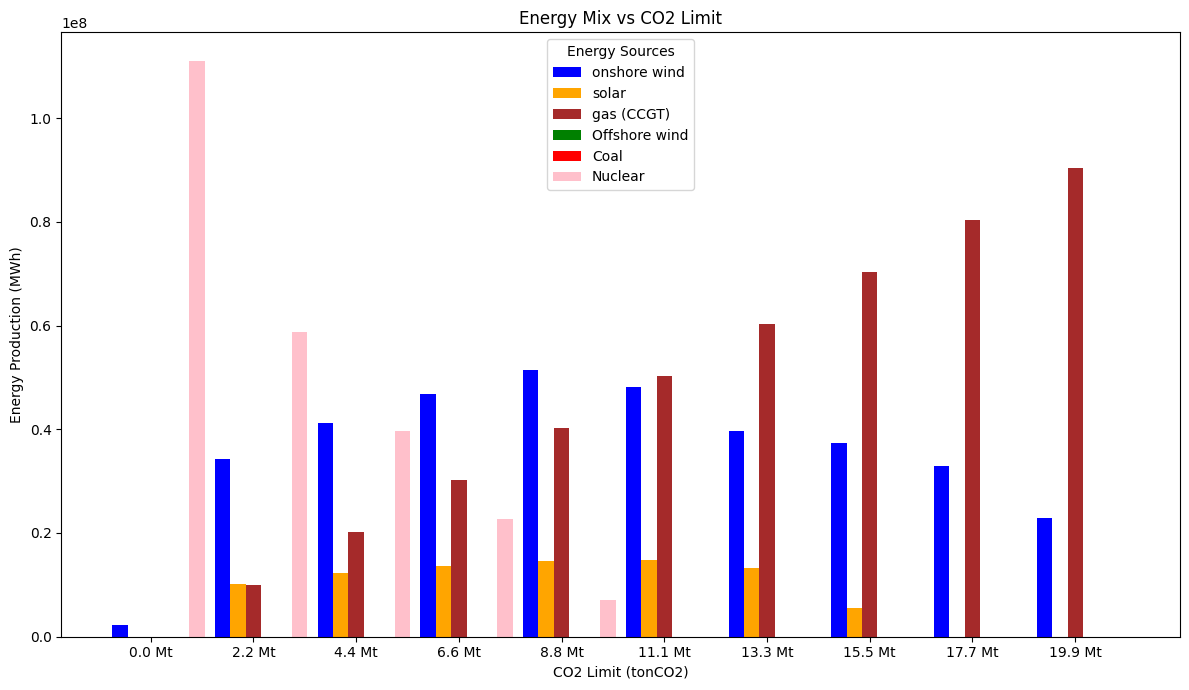

CO2 Prices for each CO2 limit:
CO2 Limit: 0.0 Mt, CO2 Price: 2417867.0606243275 EUR/ton
CO2 Limit: 2.2 Mt, CO2 Price: 464.7566155192335 EUR/ton
CO2 Limit: 4.4 Mt, CO2 Price: 351.3523560435923 EUR/ton
CO2 Limit: 6.6 Mt, CO2 Price: 316.35500285934586 EUR/ton
CO2 Limit: 8.8 Mt, CO2 Price: 296.77815930427016 EUR/ton
CO2 Limit: 11.1 Mt, CO2 Price: 206.4966404246268 EUR/ton
CO2 Limit: 13.3 Mt, CO2 Price: 97.86648919007396 EUR/ton
CO2 Limit: 15.5 Mt, CO2 Price: 55.41288101885681 EUR/ton
CO2 Limit: 17.7 Mt, CO2 Price: 28.388333638102807 EUR/ton
CO2 Limit: 19.9 Mt, CO2 Price: 6.676160702789487 EUR/ton


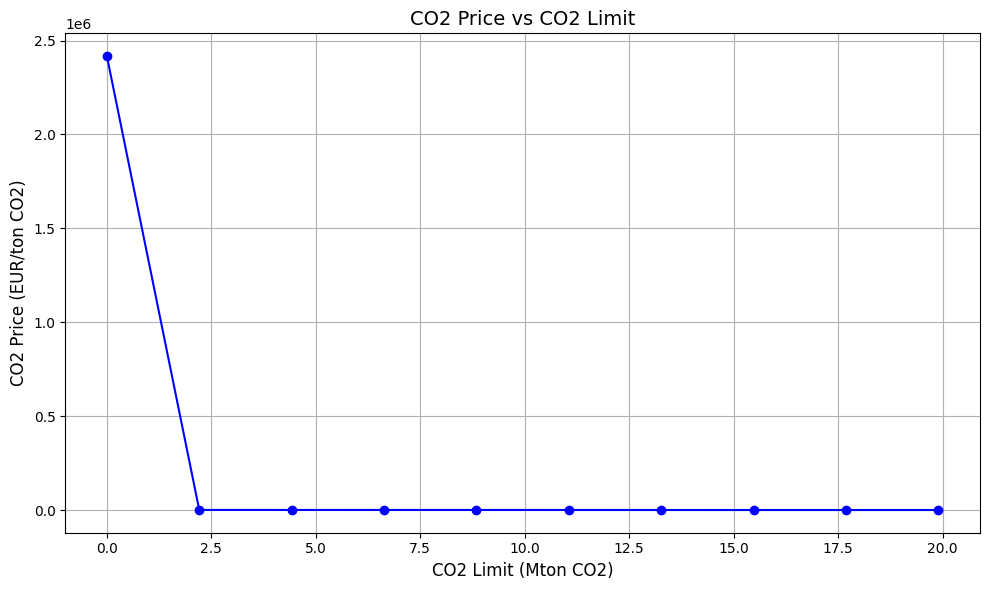

In [19]:
import numpy as np 
co2_limits = np.linspace(0, 19.9e6, 10)  
co2_prices = []
network.remove("GlobalConstraint", "co2_limit_13MT") 

energy_mixes = []
for co2_limit in co2_limits:
    
    network.add("GlobalConstraint",
                "co2_limit",  
                type="primary_energy",
                carrier_attribute="co2_emissions",
                sense="<=",
                constant=co2_limit,
                overwrite=True)
    
    network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})

    co2_price = -network.global_constraints.at['co2_limit', 'mu']
    co2_prices.append(co2_price)

    sizes = [network.generators_t.p['onshorewind'].sum(),
             network.generators_t.p['solar'].sum(),
             network.generators_t.p['CCGT'].sum(),
             network.generators_t.p['offshorewind'].sum(),
             network.generators_t.p['coal'].sum(),
             network.generators_t.p['nuclear'].sum()]
    energy_mixes.append(sizes)


energy_mixes = np.array(energy_mixes)


# Plot
labels = ['onshore wind', 'solar', 'gas (CCGT)', 'Offshore wind', 'Coal', 'Nuclear']
colors = ['blue', 'orange', 'brown', 'green', 'red', 'pink']
fig, ax1 = plt.subplots(figsize=(12, 7))
x = np.arange(len(co2_limits)) 
bar_width = 0.15 
for i, label in enumerate(labels):
    ax1.bar(x + i * bar_width, energy_mixes[:, i], bar_width, label=label, color=colors[i])
ax1.set_xlabel('CO2 Limit (tonCO2)')
ax1.set_ylabel('Energy Production (MWh)')
ax1.set_title('Energy Mix vs CO2 Limit')
ax1.set_xticks(x + bar_width * 2) 
ax1.set_xticklabels([f'{co2_limit / 1e6:.1f} Mt' for co2_limit in co2_limits]) 
ax1.legend(title="Energy Sources")
fig.tight_layout()

plt.show()


print("CO2 Prices for each CO2 limit:")
for co2_limit, co2_price in zip(co2_limits, co2_prices):
    print(f"CO2 Limit: {co2_limit / 1e6:.1f} Mt, CO2 Price: {co2_price} EUR/ton")


fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(co2_limits / 1e6, co2_prices, marker='o', linestyle='-', color='b')
ax1.set_xlabel('CO2 Limit (Mton CO2)', fontsize=12)
ax1.set_ylabel('CO2 Price (EUR/ton CO2)', fontsize=12)
ax1.set_title('CO2 Price vs CO2 Limit', fontsize=14)
ax1.grid(True)

plt.tight_layout()
plt.show()



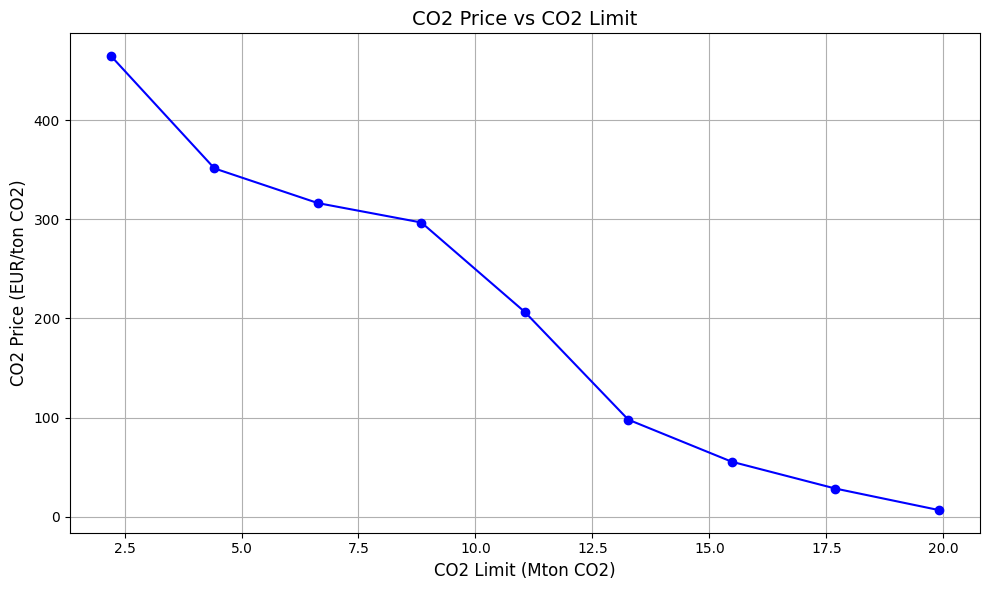

In [20]:
mask = co2_limits >= 2.2e6
co2_limits = co2_limits[mask]
co2_prices = np.array(co2_prices)[mask]

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(co2_limits / 1e6, co2_prices, marker='o', linestyle='-', color='b')
ax1.set_xlabel('CO2 Limit (Mton CO2)', fontsize=12)
ax1.set_ylabel('CO2 Price (EUR/ton CO2)', fontsize=12)
ax1.set_title('CO2 Price vs CO2 Limit', fontsize=14)
ax1.grid(True)
plt.tight_layout()
plt.show()




In [21]:
co2_limit=13000000#tonCO2
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit, 
            overwrite=True)

#network.optimize(solver_name='gurobi')
network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})

print(network.objective/1000000) #in 10^6 €

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 11.86it/s]
INFO:linopy.io: Writing time: 1.38s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-st2d9p0y.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-st2d9p0y.lp


Reading time = 0.43 seconds


INFO:gurobipy:Reading time = 0.43 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 6.92e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


6923.799911090628


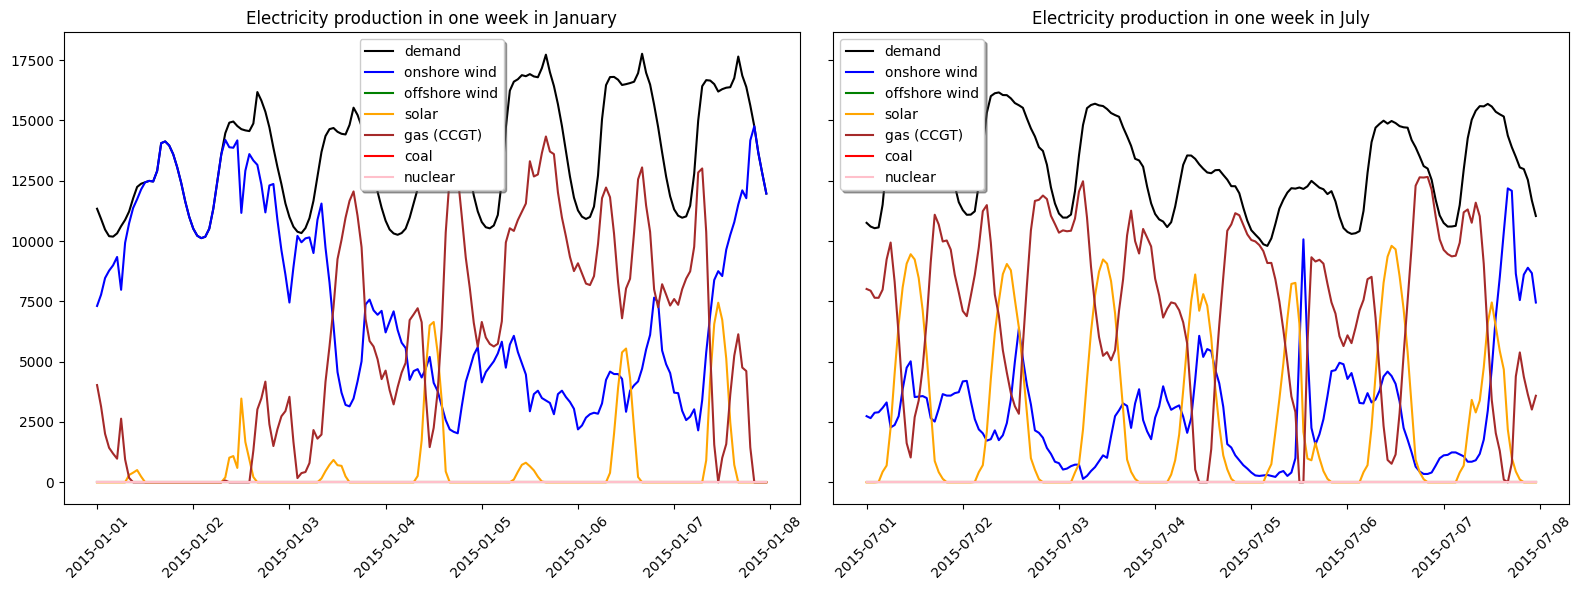

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Part C. Plotting Average Capacity and variability for every generator

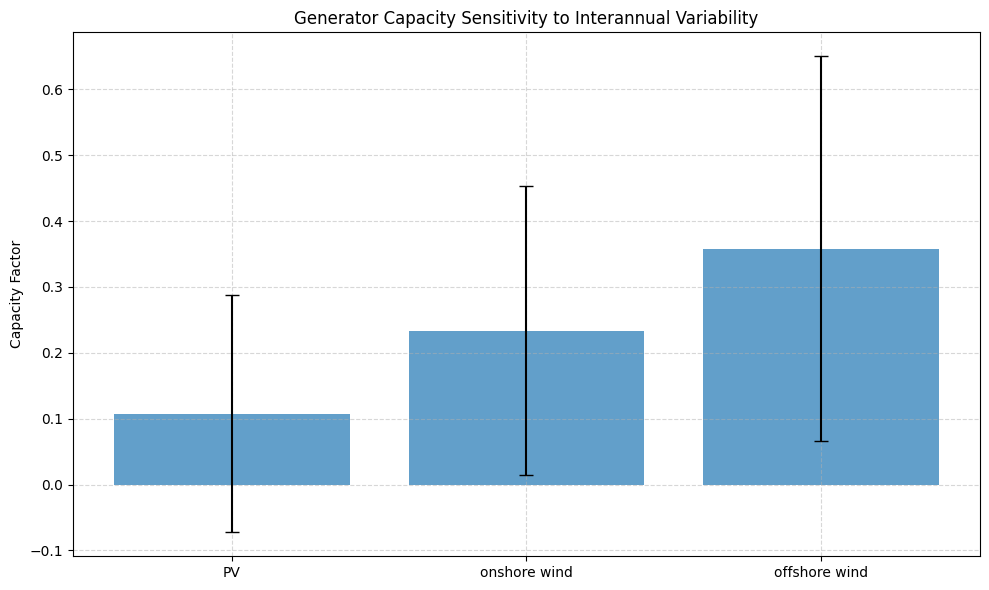

In [23]:
#calculating the average capacity for each generator using different years
Country = 'NLD'

data_pv = pd.read_csv('Data/pv_optimal.csv', sep=';', index_col=0)
data_pv.index = pd.to_datetime(data_pv.index)
CF_pv = data_pv[country]['1979-1-01T00:00:00Z':'2017-12-31T23:00:00Z']

data_onshore_wind = pd.read_csv('Data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
data_onshore_wind.index = pd.to_datetime(data_onshore_wind.index)
CF_onshore_wind = data_onshore_wind[country]['1979-1-01T00:00:00Z':'2017-12-31T23:00:00Z']

data_offshore_wind = pd.read_csv('Data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
data_offshore_wind.index = pd.to_datetime(data_offshore_wind.index)
CF_offshore_wind = data_offshore_wind[country]['1979-1-01T00:00:00Z':'2017-12-31T23:00:00Z']

CF_all = pd.concat([CF_pv.rename('PV'),
                    CF_onshore_wind.rename('onshore wind'),
                    CF_offshore_wind.rename('offshore wind')], axis=1)

average = CF_all.mean()
std_dev = CF_all.std()

plt.figure(figsize=(10, 6))
plt.bar(average.index, average.values, yerr=std_dev.values, capsize=5, alpha = 0.7)
plt.ylabel('Capacity Factor')
plt.title('Generator Capacity Sensitivity to Interannual Variability')
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()






Part D. Adding Storage Technology

In [24]:
network.add("Carrier", "battery")
network.add("Carrier", "Pumped Hydro")

# add storage units (battery and pumped hydro)
network.add("StorageUnit", "battery", 
            bus="electricity bus",
            p_nom=300000,
            max_hours=4.5,
            p_nom_extendable = True,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=350000,
            marginal_cost=0,
            carrier="battery",
            overwrite = True)

network.add("StorageUnit", "Pumped Hydro", 
            bus="electricity bus",
            p_nom=500,
            p_nom_extendable = True,
            max_hours=12,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=2000000,
            marginal_cost=0,
            carrier="Pumped Hydro",
            overwrite = True)


Index(['Pumped Hydro'], dtype='object')

In [25]:
network.storage_units.head(3)

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
battery,electricity bus,PQ,,300000.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,4.5,0.9,0.9,0.0,0.0,0.0
Pumped Hydro,electricity bus,PQ,,500.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,12.0,0.9,0.9,0.0,0.0,0.0


In [26]:
network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 16.70it/s]
INFO:linopy.io: Writing time: 2.85s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-bycaqbrx.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-bycaqbrx.lp


Reading time = 0.88 seconds


INFO:gurobipy:Reading time = 0.88 seconds


obj: 236529 rows, 105129 columns, 486175 nonzeros


INFO:gurobipy:obj: 236529 rows, 105129 columns, 486175 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105129 primals, 236529 duals
Objective: -9.91e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [27]:
p_nom_opt_batt = network.storage_units.loc["battery", "p_nom_opt"]
p_nom_opt_pump = network.storage_units.loc["Pumped Hydro", "p_nom_opt"]
print(p_nom_opt_batt)
print(p_nom_opt_pump)

0.0
0.0


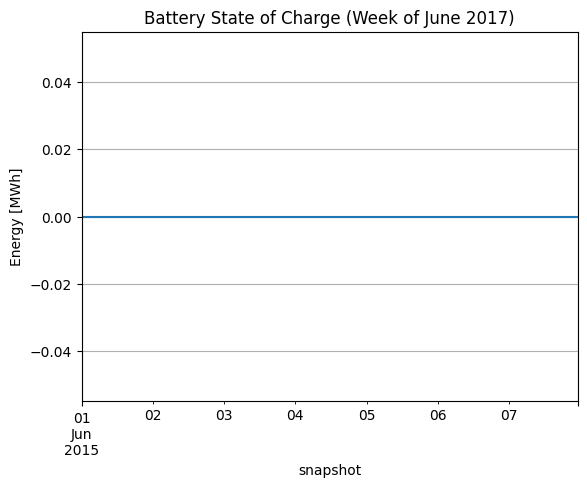

In [28]:
network.storage_units_t.state_of_charge["battery"].loc["2015-06-01":"2015-06-07"].plot()
plt.title("Battery State of Charge (Week of June 2017)")
plt.ylabel("Energy [MWh]")
plt.grid()
plt.show()


Part E: target for decarbonization

In [29]:
co2_price = -network.global_constraints.at['co2_limit', 'mu']


print(f"CO2 Limit: {co2_limit / 1e6:.1f} Mt, CO2 Price: {co2_price}")


CO2 Limit: 13.0 Mt, CO2 Price: 105.90683244155875


Part F: Connect your country with, at least, two neighbouring countries.

In [30]:
file_path = "Data/electricity_demand.csv"
raw_data = pd.read_csv(file_path, sep=';', parse_dates=['utc_time'], index_col='utc_time')
raw_data.index = pd.to_datetime(raw_data.index, utc=True)

start_date = '2015-01-01 00:00:00+00:00'
end_date = '2015-12-31 23:00:00+00:00'
data_all = raw_data[start_date:end_date]



network.add("Bus", "electricity bus DNK", carrier="electricity")
network.add("Bus", "electricity bus GBR", carrier="electricity")


network.add("Load", "load DNK", bus="electricity bus DNK", p_set=data_all['DNK'].values)
network.add("Load", "load GBR", bus="electricity bus GBR", p_set=data_all['GBR'].values)

network.add("Link",
            "COBRAcable (NLD-DNK)",
            bus0="electricity bus",
            bus1="electricity bus DNK",
            p_nom=700,
            p_min_pu=-1,
            length=325,
            capital_cost=857142.86)


network.add("Link",
            "BritNed (NLD-GBR)",
            bus0="electricity bus",
            bus1="electricity bus GBR",
            p_nom=1000,  
            p_min_pu=-1,
            length=260,
            capital_cost=500000)



Index(['BritNed (NLD-GBR)'], dtype='object')

In [31]:
# Generatorer
network.add("Generator", 
            "generator DK",
            bus="electricity bus DNK",
            p_nom_extendable=True,
            p_nom_max=18204, 
            overwrite=True)

network.add("Generator", 
            "generator GB",
            bus="electricity bus GBR",
            p_nom_extendable=True,
            p_nom_max=101000, 
            overwrite=True)

Index(['generator GB'], dtype='object')

In [32]:

network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})

# Hent og print optimal kapasitet
print("Optimal kapasitet (MW):")
print(network.links.p_nom_opt)


network.generators.p_nom_opt

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 12.76it/s]
INFO:linopy.io: Writing time: 3.96s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-r7ct9zzl.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-r7ct9zzl.lp


Reading time = 1.52 seconds


INFO:gurobipy:Reading time = 1.52 seconds


obj: 324133 rows, 140171 columns, 626339 nonzeros


INFO:gurobipy:obj: 324133 rows, 140171 columns, 626339 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140171 primals, 324133 duals
Objective: -1.00e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Optimal kapasitet (MW):
Link
COBRAcable (NLD-DNK)     700.0
BritNed (NLD-GBR)       1000.0
Name: p_nom_opt, dtype: float64


Generator
onshorewind      16028.846154
offshorewind         0.000000
solar             6750.021308
CCGT             15710.740385
coal                 0.000000
nuclear              0.000000
generator DK     18204.000000
generator GB    101000.000000
Name: p_nom_opt, dtype: float64

In [33]:
print("COBRAcable total p0:", network.links_t.p0['COBRAcable (NLD-DNK)'].sum())
print("BritNed total p0:", network.links_t.p0['BritNed (NLD-GBR)'].sum())

COBRAcable total p0: -6132000.0
BritNed total p0: -8760000.0


Annual electricity generation per generator type (in GWh):

onshorewind      32508.461058
offshorewind         0.000000
solar             6758.506851
CCGT             59090.909091
coal                 0.000000
nuclear              0.000000
generator DK     38945.939130
generator GB    290955.189000
dtype: float64


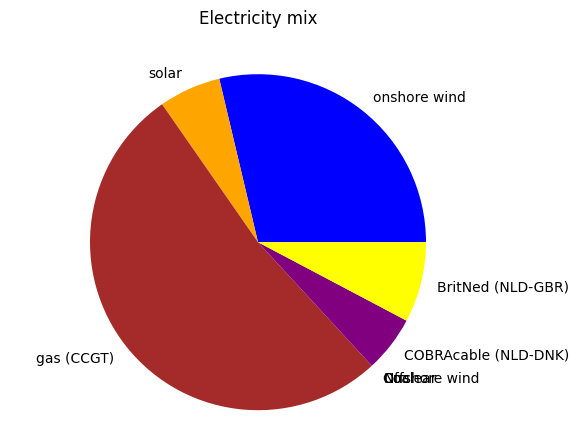

In [34]:
labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear', 
          'COBRAcable (NLD-DNK)',
          'BritNed (NLD-GBR)']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum(),
        network.generators_t.p['nuclear'].sum(),
        abs(network.links_t.p0['COBRAcable (NLD-DNK)'].sum()),
        abs(network.links_t.p0['BritNed (NLD-GBR)'].sum())
        ]

colors=['blue', 'orange', 'brown', 'green', 'red', 'pink', 'purple', 'yellow']    

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

network.generators.p_nom_opt # in MW
generation_mwh = network.generators_t.p.sum()  # Sum over all hours → MWh
generation_gwh = generation_mwh / 1000         # Convert MWh to GWh

# Print results
print("Annual electricity generation per generator type (in GWh):\n")
print(generation_gwh)

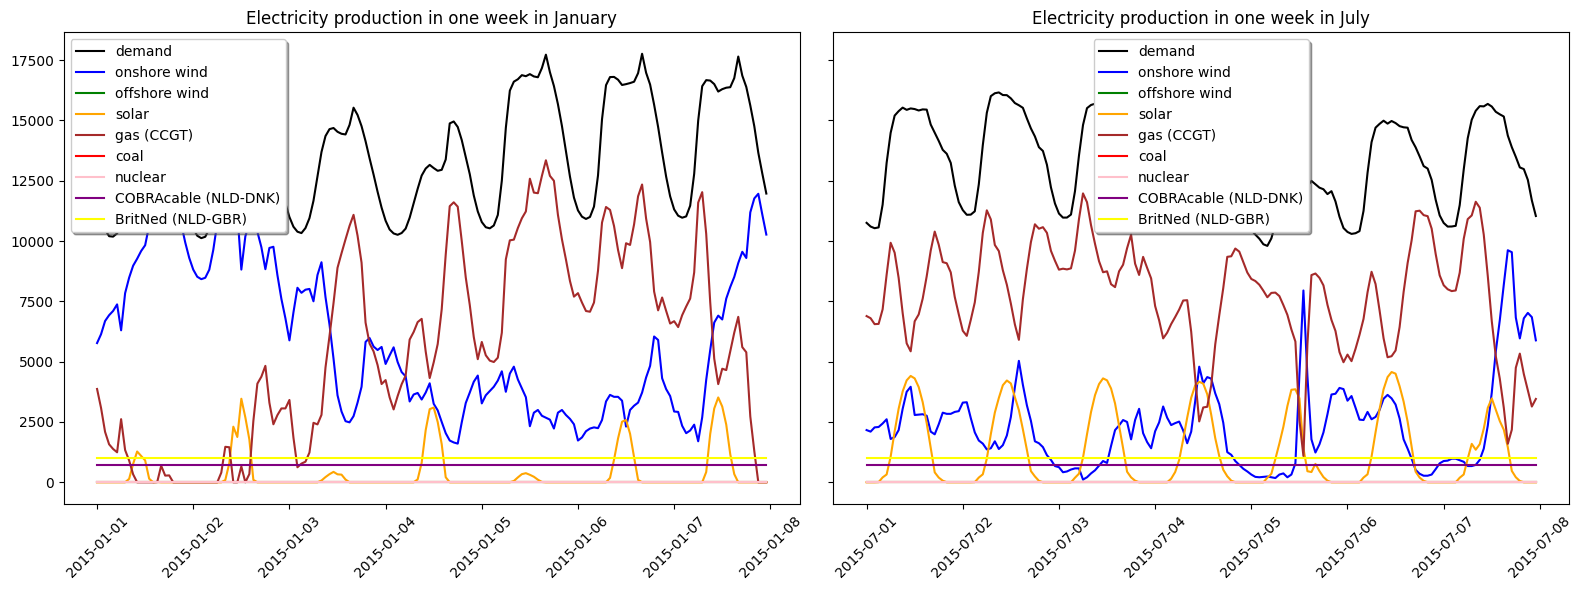

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].plot(abs(network.links_t.p0['COBRAcable (NLD-DNK)'][0:168]), color='purple', label='COBRAcable (NLD-DNK)')
axes[0].plot(abs(network.links_t.p0['BritNed (NLD-GBR)'][0:168]), color='yellow', label='BritNed (NLD-GBR)')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].plot(abs(network.links_t.p0['COBRAcable (NLD-DNK)'][4344:4512]), color='purple', label='COBRAcable (NLD-DNK)')
axes[1].plot(abs(network.links_t.p0['BritNed (NLD-GBR)'][4344:4512]), color='yellow', label='BritNed (NLD-GBR)')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [36]:
cobra_flow = network.links_t.p0['COBRAcable (NLD-DNK)'].sum()
britned_flow = network.links_t.p0['BritNed (NLD-GBR)'].sum()

cobra_export_from_nld = max(cobra_flow, 0)
cobra_import_to_nld   = abs(min(cobra_flow, 0))

print("COBRAcable export from NLD:", cobra_export_from_nld)
print("COBRAcable import to NLD:", cobra_import_to_nld)

britned_export_from_nld = max(britned_flow, 0)
britned_import_to_nld   = abs(min(britned_flow, 0))

print("BritNed export from NLD:", britned_export_from_nld)
print("BritNed import to NLD:", britned_import_to_nld)


COBRAcable export from NLD: 0
COBRAcable import to NLD: 6132000.0
BritNed export from NLD: 0
BritNed import to NLD: 8760000.0


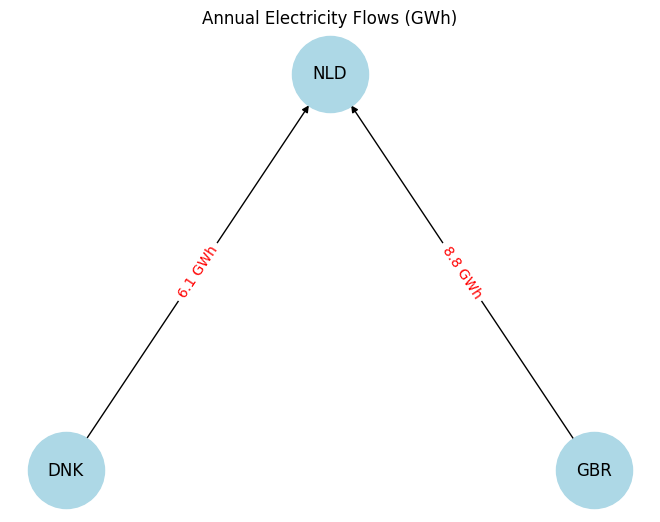

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.DiGraph()

# Add nodes
G.add_node("DNK")
G.add_node("GBR")
G.add_node("NLD")

# Add edges with weights (you can reverse direction depending on actual flows)
if cobra_flow > 0:
    G.add_edge("NLD", "DNK", weight=cobra_flow)
else:
    G.add_edge("DNK", "NLD", weight=abs(cobra_flow))

if britned_flow > 0:
    G.add_edge("NLD", "GBR", weight=britned_flow)
else:
    G.add_edge("GBR", "NLD", weight=abs(britned_flow))

# Draw
pos = {"DNK": (-1, 0), "NLD": (0, 1), "GBR": (1, 0)}
weights = [G[u][v]['weight'] / 1e6 for u, v in G.edges()]  # In MW or MWh

nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', arrows=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={(u, v): f"{G[u][v]['weight'] / 1e6:.1f} GWh" for u, v in G.edges()},
    font_color='red'
)

plt.title("Annual Electricity Flows (GWh)")
plt.show()


## G. 


In [39]:
network.add("Carrier", "heat")


network.add("Bus",
            "heat bus",
            carrier="heat")

network.add("Bus", 
            "useful heat bus",
            carrier = "heat")

file_path_heat = "Data/heat_demand.csv"
heat_data = pd.read_csv(file_path_heat, sep=';', parse_dates=['utc_time'], index_col='utc_time')
heat_data.index = pd.to_datetime(heat_data.index, utc=True)


country = 'NLD'
heat_demand = heat_data[country]



heat_demand.index = heat_demand.index.tz_localize(None)
network.snapshots = network.snapshots.tz_localize(None)


heat_demand = heat_demand.reindex(network.snapshots, method='nearest')




In [40]:
network.add("Load",
            "heat load",
            bus="heat bus",
            p_set=heat_demand.values)

network.add("Store",
            "heat tank",
            bus="heat bus",
            e_nom_extendable=True,
            e_cyclic=True,
            capital_cost=annuity(25, 0.07)* 21420*(1+0.01))  

network.add("Link",
            "heat discharger",
            bus0="heat bus",
            bus1="useful heat bus",  # eller evt. en egen bus om nødvendig
            p_nom_extendable=True,
            efficiency=0.63,  # fra tabellen din
            capital_cost=annuity(33, 0.07) * 550809 * (1 + 0.03),  # justert kost
            carrier="heat")

network.add("Link",
            "heat pump",
            bus0="electricity bus",
            bus1="heat bus",
            p_nom_extendable=True,
            efficiency=0.99,
            capital_cost=annuity(5, 0.07)*784486*(1+0.03),  
            carrier="heat")


network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 12/12 [00:00<00:00, 16.16it/s]
INFO:linopy.io: Writing time: 4.2s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-22bhxydu.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-22bhxydu.lp


Reading time = 1.41 seconds


INFO:gurobipy:Reading time = 1.41 seconds


obj: 402976 rows, 175214 columns, 775262 nonzeros


INFO:gurobipy:obj: 402976 rows, 175214 columns, 775262 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 175214 primals, 402976 duals
Objective: -8.10e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [41]:
print("Optimal heat pump (MW):")
print(network.links.p_nom_opt[["heat pump"]])
print("Optimal heat tank (MWh):")
print(network.stores.e_nom_opt["heat tank"])

print(heat_demand.describe())
print(heat_demand.head())

Optimal heat pump (MW):
Link
heat pump    33825.248898
Name: p_nom_opt, dtype: float64
Optimal heat tank (MWh):
1011026.9919957562
count     8760.000000
mean     15844.849242
std      10169.239646
min       1837.890303
25%       7049.810280
50%      14746.807229
75%      24081.871112
max      41510.859460
Name: NLD, dtype: float64
snapshot
2015-01-01 00:00:00    30208.769643
2015-01-01 01:00:00    30178.483595
2015-01-01 02:00:00    30656.801254
2015-01-01 03:00:00    31221.195229
2015-01-01 04:00:00    31682.524876
Name: NLD, dtype: float64


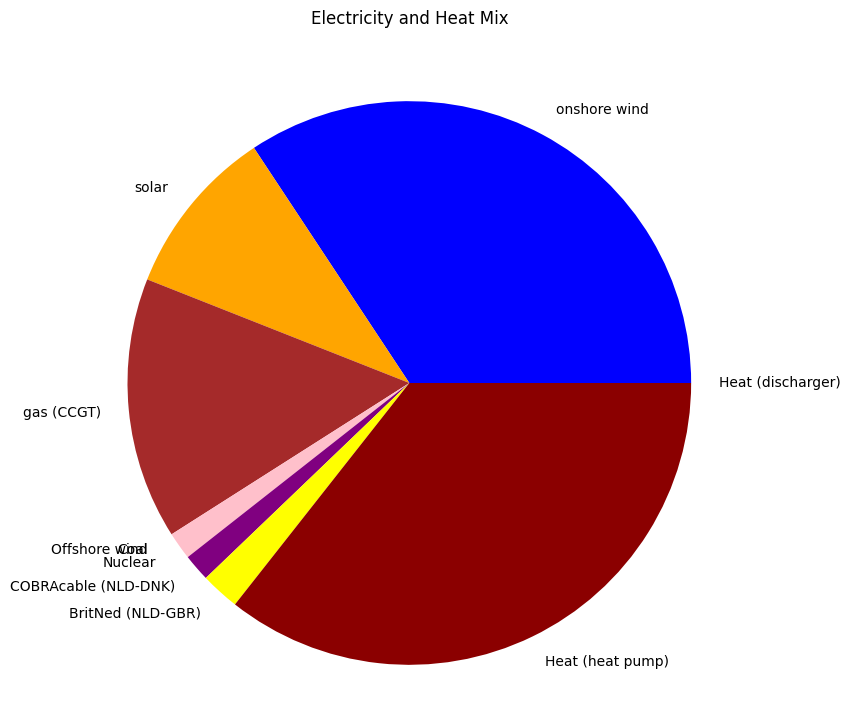

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

def safe_sum(series):
    return series.sum() if isinstance(series, pd.Series) else 0

labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear', 
          'COBRAcable (NLD-DNK)',
          'BritNed (NLD-GBR)',
          'Heat (heat pump)',
          'Heat (discharger)']

sizes = [
    network.generators_t.p.get('onshorewind', pd.Series(0, index=network.snapshots)).sum(),
    network.generators_t.p.get('solar', pd.Series(0, index=network.snapshots)).sum(),
    network.generators_t.p.get('CCGT', pd.Series(0, index=network.snapshots)).sum(),
    network.generators_t.p.get('offshorewind', pd.Series(0, index=network.snapshots)).sum(),
    network.generators_t.p.get('coal', pd.Series(0, index=network.snapshots)).sum(),
    network.generators_t.p.get('nuclear', pd.Series(0, index=network.snapshots)).sum(),
    abs(network.links_t.p0.get('COBRAcable (NLD-DNK)', pd.Series(0, index=network.snapshots)).sum()),
    abs(network.links_t.p0.get('BritNed (NLD-GBR)', pd.Series(0, index=network.snapshots)).sum()),
    safe_sum(network.links_t.p0.get('heat pump', pd.Series(0, index=network.snapshots))),
    safe_sum(network.links_t.p0.get('heat discharger', pd.Series(0, index=network.snapshots)))
]

# Force all sizes to positive (if not already done)
sizes = [abs(s) for s in sizes]

colors = ['blue', 'orange', 'brown', 'green', 'red', 'pink', 'purple', 'yellow', 'darkred', 'firebrick']

plt.figure(figsize=(8, 8))
plt.pie(sizes, colors=colors, labels=labels, wedgeprops={'linewidth': 0})
plt.axis('equal')
plt.title('Electricity and Heat Mix', y=1.07)
plt.show()


In [44]:
network.generators.p_nom_opt # in MW

Generator
onshorewind      73306.900009
offshorewind         0.000000
solar            50442.424351
CCGT             34845.768940
coal                 0.000000
nuclear           1232.109068
generator DK     18204.000000
generator GB    101000.000000
Name: p_nom_opt, dtype: float64

In [45]:

network.add("Carrier", "lion_battery", overwrite = True)
network.add("StorageUnit", "lion_battery", 
            bus="electricity bus",
            p_nom_max = 350,
            max_hours=4,
            p_nom_extendable = True,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=annuity(15,0.007)*300000,  # €/MW
            marginal_cost=0,
            carrier="battery",
            overwrite = True,
            cyclic_state_of_charge=True)

network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 12/12 [00:00<00:00, 18.45it/s]
INFO:linopy.io: Writing time: 4.51s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-daanru2k.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-daanru2k.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 464298 rows, 201495 columns, 906664 nonzeros


INFO:gurobipy:obj: 464298 rows, 201495 columns, 906664 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 201495 primals, 464298 duals
Objective: -8.10e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

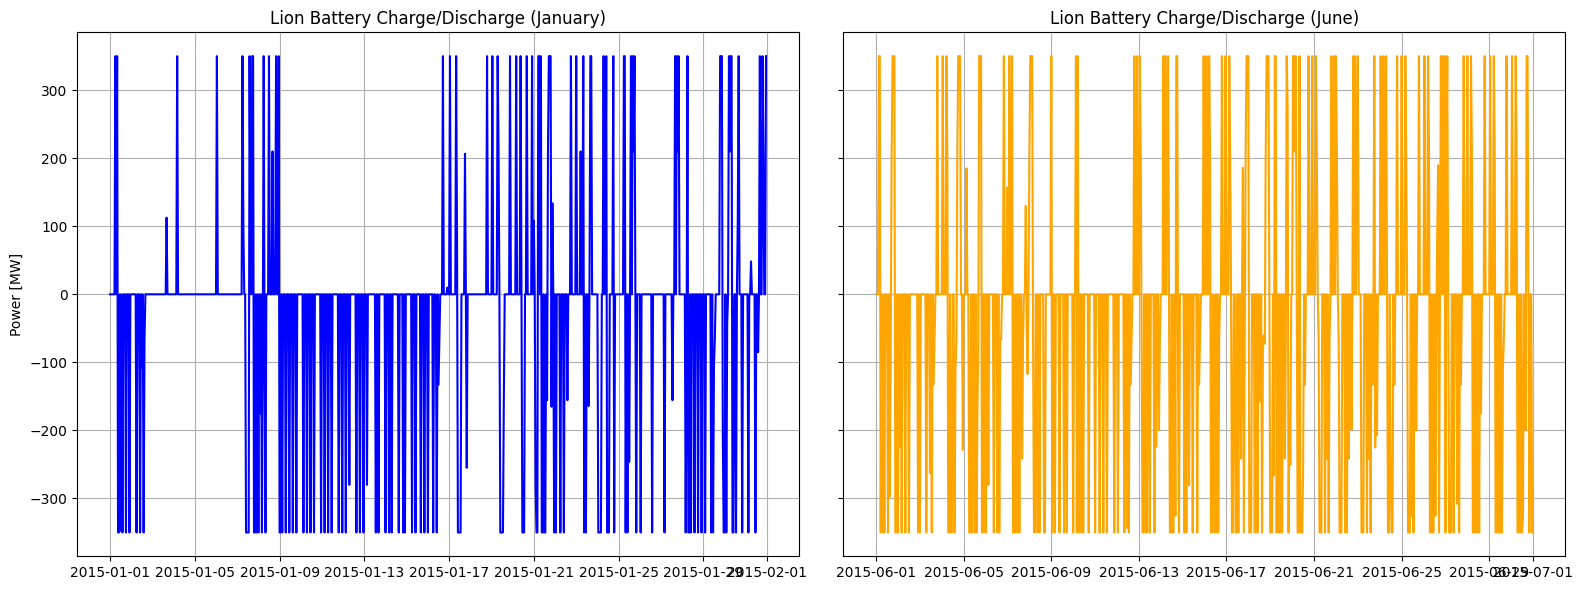

In [46]:
#Analyzing the Charging/Discharging Behavior of the Lion Battery for one Month in January and June
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# January
axes[0].plot(network.storage_units_t.p["lion_battery"].loc["2015-01-01":"2015-01-31"], color='blue')
axes[0].set_title("Lion Battery Charge/Discharge (January)")
axes[0].set_ylabel("Power [MW]")
axes[0].grid()

# June
axes[1].plot(network.storage_units_t.p["lion_battery"].loc["2015-06-01":"2015-06-30"], color='orange')
axes[1].set_title("Lion Battery Charge/Discharge (June)")
axes[1].grid()

plt.tight_layout()
plt.show()



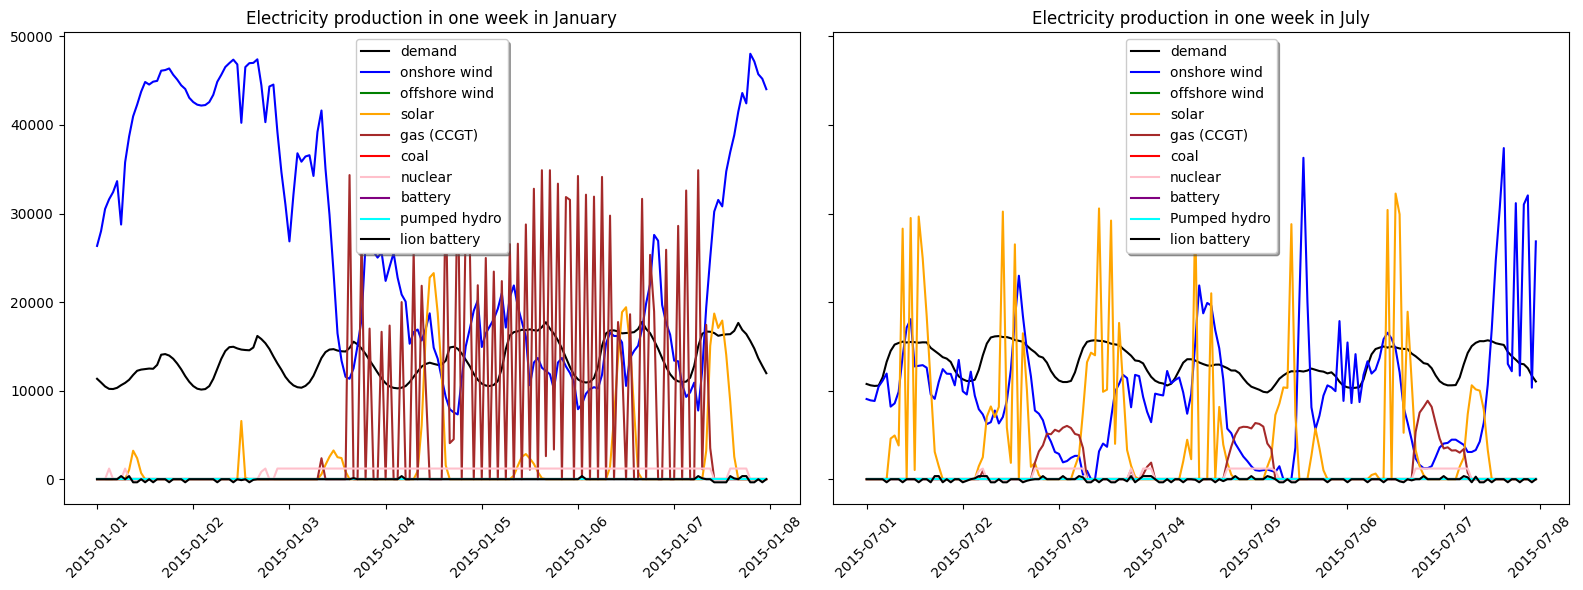

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].plot(network.storage_units_t.p['battery'][0:168], color='purple', label='battery')
axes[0].plot(network.storage_units_t.p['Pumped Hydro'][0:168], color='cyan', label='pumped hydro')
axes[0].plot(network.storage_units_t.p['lion_battery'][0:168], color='black', label='lion battery')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].plot(network.storage_units_t.p['battery'][4344:4512], color='purple', label='battery')
axes[1].plot(network.storage_units_t.p['Pumped Hydro'][4344:4512], color='cyan', label='Pumped hydro')
axes[1].plot(network.storage_units_t.p['lion_battery'][4344:4512], color='black', label='lion battery')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()